# Geographic Distribution Within India

Where in India are citizen science observations concentrated?

In [1]:
import sys; sys.path.insert(0, ".")
from _shared import *
from scipy.spatial import cKDTree
setup_plotting()

india_df = pd.read_parquet(CACHE_DIR / "india_df.parquet")

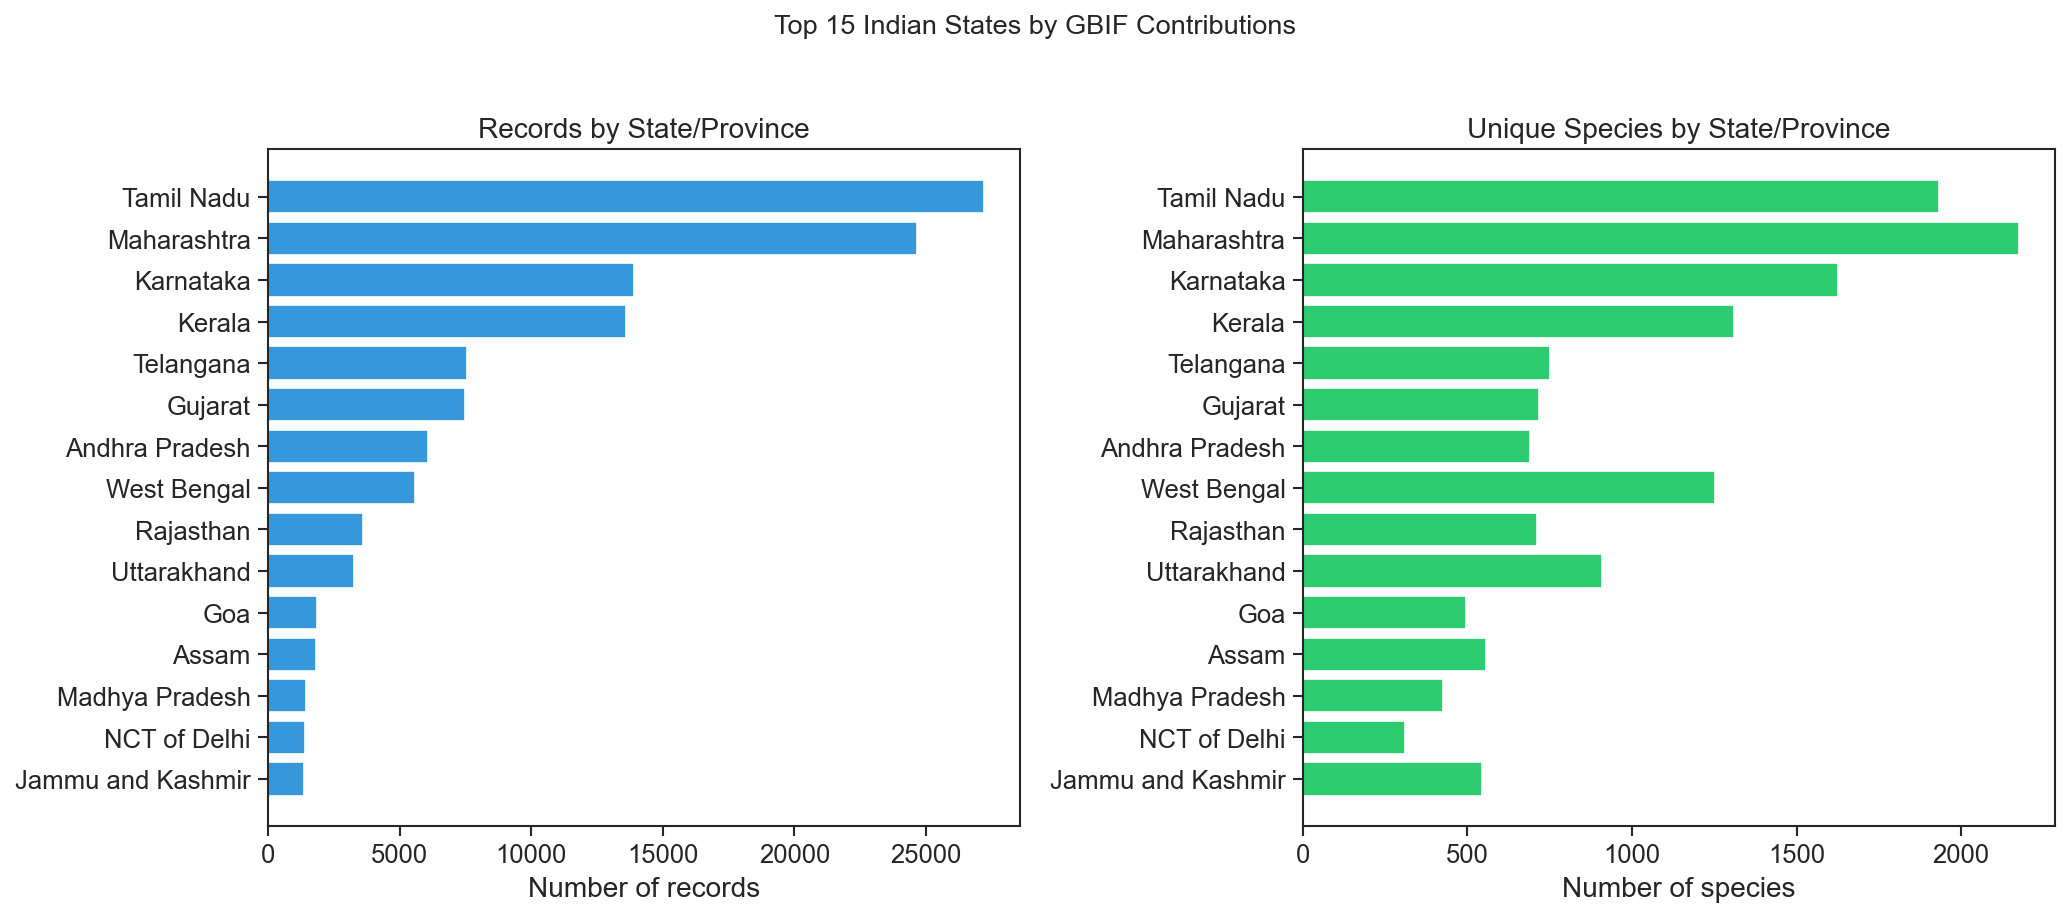

In [2]:
# Figure 3: State-level analysis
state_counts = (
    india_df.groupby("stateprovince")
    .agg(n_records=("species", "size"), n_species=("species", "nunique"))
    .sort_values("n_records", ascending=False)
)

top_states = state_counts.head(15)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].barh(top_states.index[::-1], top_states.n_records[::-1], color="#3498db")
axes[0].set_title("Records by State/Province")
axes[0].set_xlabel("Number of records")

axes[1].barh(top_states.index[::-1], top_states.n_species[::-1], color="#2ecc71")
axes[1].set_title("Unique Species by State/Province")
axes[1].set_xlabel("Number of species")

fig.suptitle("Top 15 Indian States by GBIF Contributions", fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

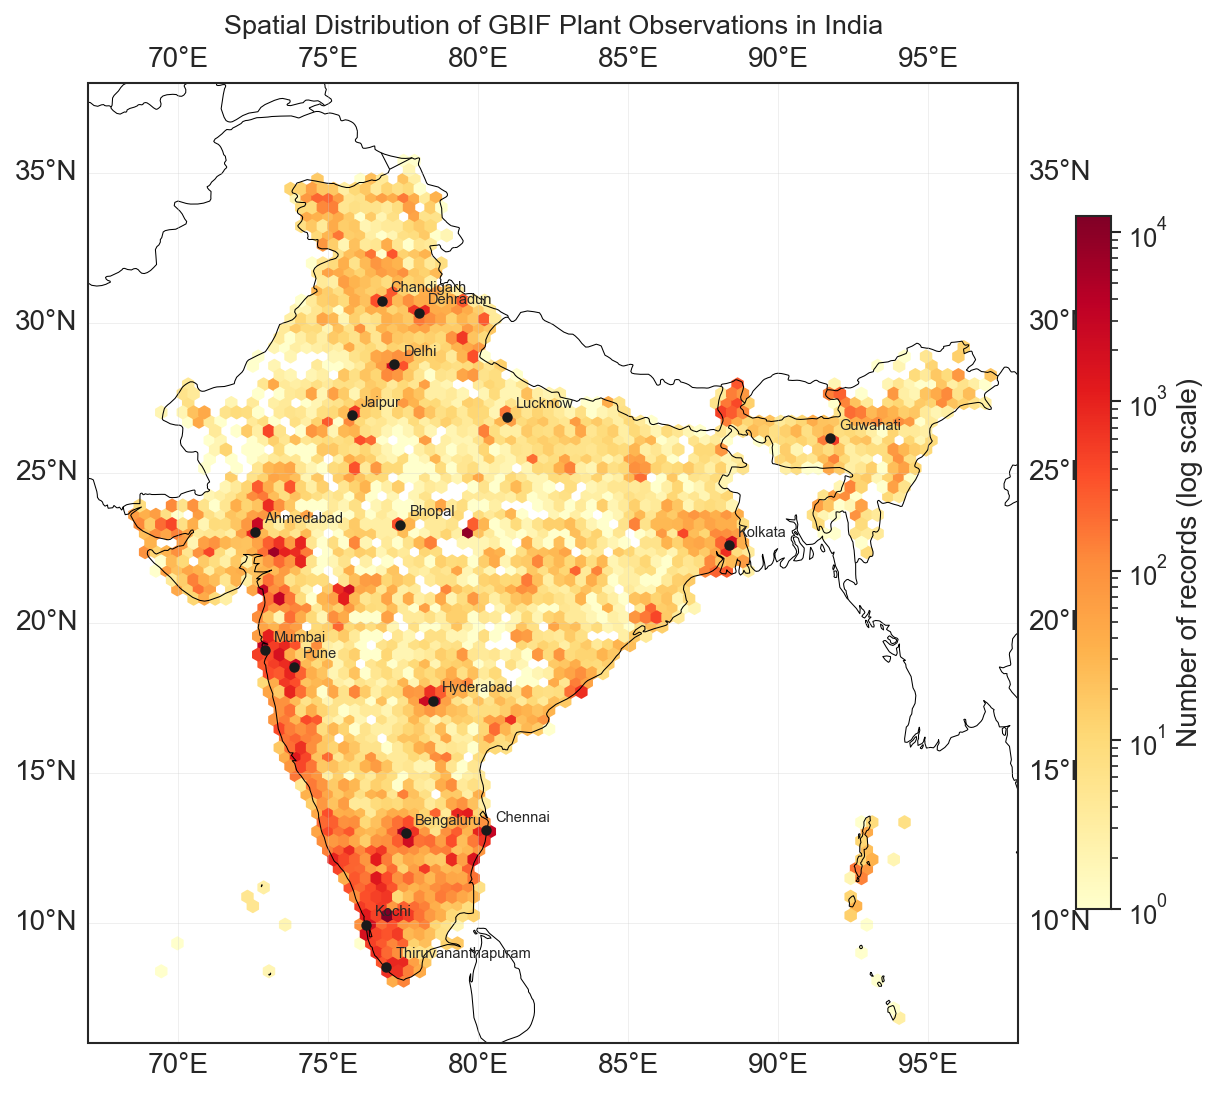

In [3]:
# Figure 4: Spatial density map of India
india_geo = india_df.dropna(subset=["decimallatitude", "decimallongitude"])

fig, ax = plt.subplots(
    figsize=(10, 10), subplot_kw={"projection": ccrs.PlateCarree()}
)

hb = ax.hexbin(
    india_geo.decimallongitude,
    india_geo.decimallatitude,
    gridsize=80,
    bins="log",
    cmap="YlOrRd",
    mincnt=1,
    transform=ccrs.PlateCarree(),
)
ax.set_extent([67, 98, 6, 38], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.gridlines(draw_labels=True, linewidth=0.3, alpha=0.5)

# Overlay city markers
for _, city in INDIA_CITIES.iterrows():
    ax.plot(city.lon, city.lat, "ko", markersize=4, transform=ccrs.PlateCarree())
    ax.text(
        city.lon + 0.3, city.lat + 0.3, city.city,
        fontsize=7, transform=ccrs.PlateCarree(),
    )

plt.colorbar(hb, ax=ax, shrink=0.6, label="Number of records (log scale)")
ax.set_title("Spatial Distribution of GBIF Plant Observations in India", fontsize=13)
plt.show()

28.1% of observations are within 50 km of a major city
44.5% of observations are within 100 km of a major city


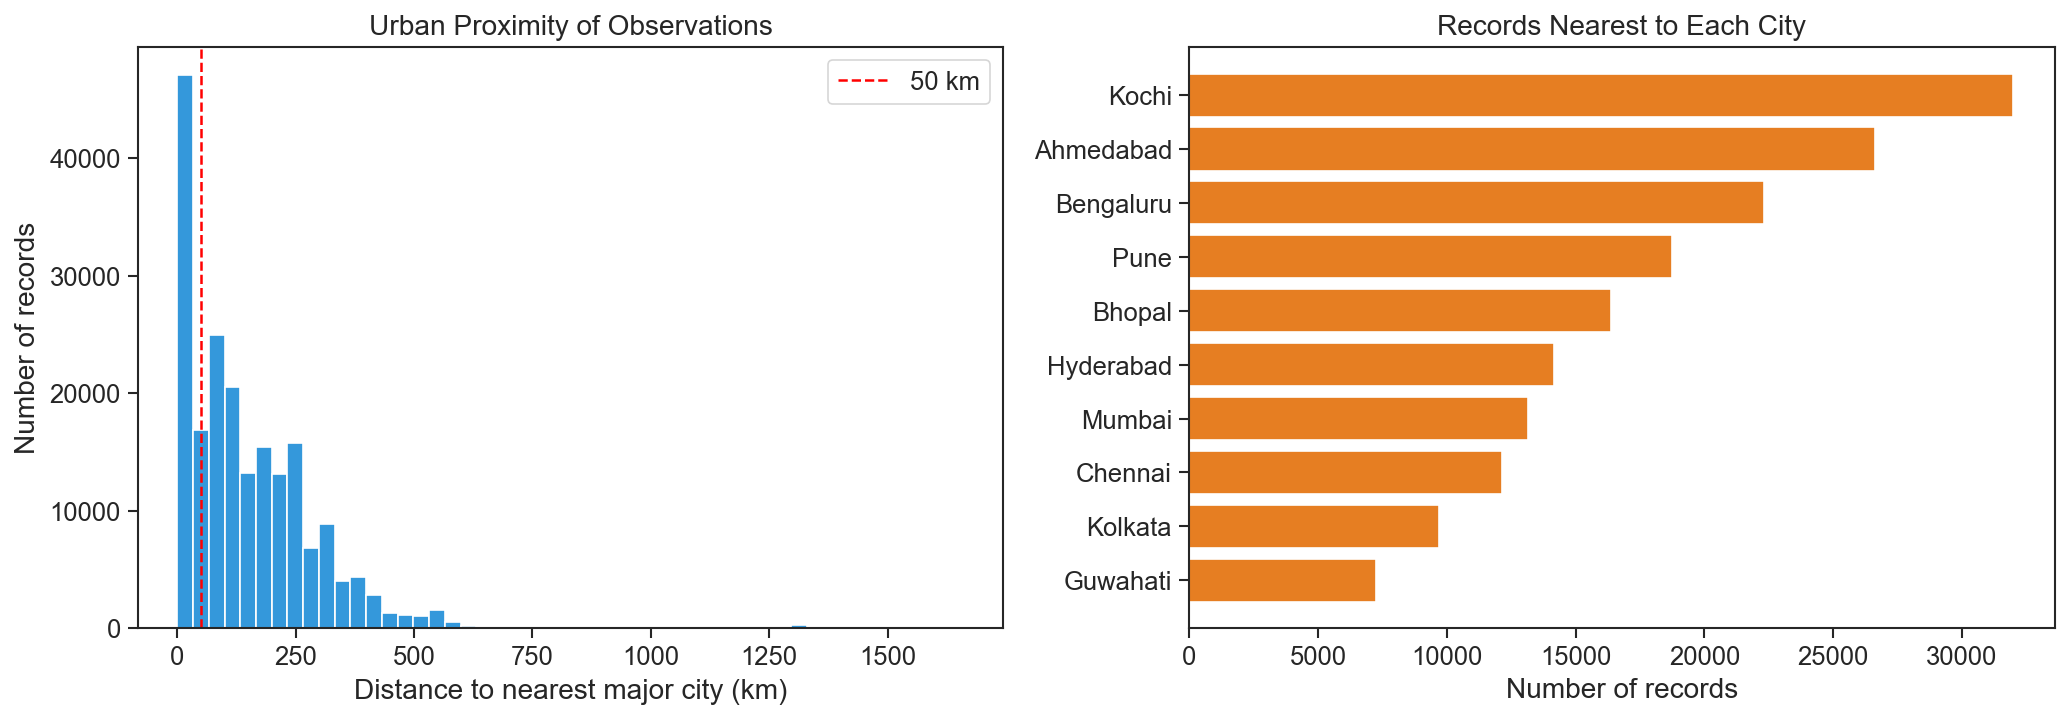

In [4]:
# Figure 5: Urban proximity analysis
city_coords = INDIA_CITIES[["lat", "lon"]].values
tree = cKDTree(city_coords)

obs_coords = india_geo[["decimallatitude", "decimallongitude"]].values
distances_deg, nearest_idx = tree.query(obs_coords)

# ~111 km per degree at India's latitude range \u2014 approximate but sufficient
india_geo = india_geo.assign(
    dist_to_city_km=distances_deg * 111,
    nearest_city=INDIA_CITIES.city.values[nearest_idx],
)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(india_geo.dist_to_city_km, bins=50, color="#3498db", edgecolor="white")
axes[0].set_xlabel("Distance to nearest major city (km)")
axes[0].set_ylabel("Number of records")
axes[0].set_title("Urban Proximity of Observations")
axes[0].axvline(x=50, color="red", linestyle="--", label="50 km")
axes[0].legend()

city_agg = india_geo.nearest_city.value_counts().head(10)
axes[1].barh(city_agg.index[::-1], city_agg.values[::-1], color="#e67e22")
axes[1].set_title("Records Nearest to Each City")
axes[1].set_xlabel("Number of records")

pct_within_50km = (india_geo.dist_to_city_km < 50).mean()
pct_within_100km = (india_geo.dist_to_city_km < 100).mean()
print(f"{pct_within_50km:.1%} of observations are within 50 km of a major city")
print(f"{pct_within_100km:.1%} of observations are within 100 km of a major city")

plt.tight_layout()
plt.show()

In [5]:
# Coverage gap analysis
india_geo = india_geo.assign(
    lat_bin=np.round(india_geo.decimallatitude * 2) / 2,
    lon_bin=np.round(india_geo.decimallongitude * 2) / 2,
)
sampled_cells = india_geo.groupby(["lat_bin", "lon_bin"]).size().reset_index(name="count")

print(f"0.5-degree grid cells with >= 1 observation: {len(sampled_cells)}")
print(f"Cells with >= 10 observations: {(sampled_cells['count'] >= 10).sum()}")
print(f"Cells with >= 100 observations: {(sampled_cells['count'] >= 100).sum()}")

0.5-degree grid cells with >= 1 observation: 1227
Cells with >= 10 observations: 882
Cells with >= 100 observations: 251
